In [2]:
!pip install qiskit-optimization 

     ---------------------------------------- 0.0/643.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/643.4 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/643.4 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/643.4 kB ? eta -:--:--
     ----------------------------- ------ 524.3/643.4 kB 837.5 kB/s eta 0:00:01
     ------------------------------------ 643.4/643.4 kB 786.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for docplex: filename=docplex-2.28.240-py3-none-any.whl size=682884 sha256=6e0a01f9c437dbedc

fval=0.0, num_leaves_31=0.0, num_leaves_50=0.0, max_depth_5=0.0, max_depth_10=0.0, learning_rate_001=0.0, learning_rate_05=0.0, status=SUCCESS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored.

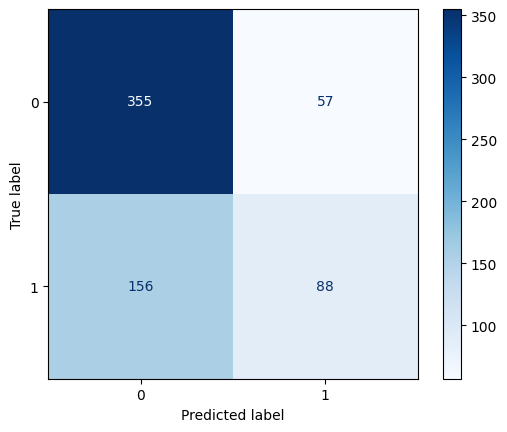

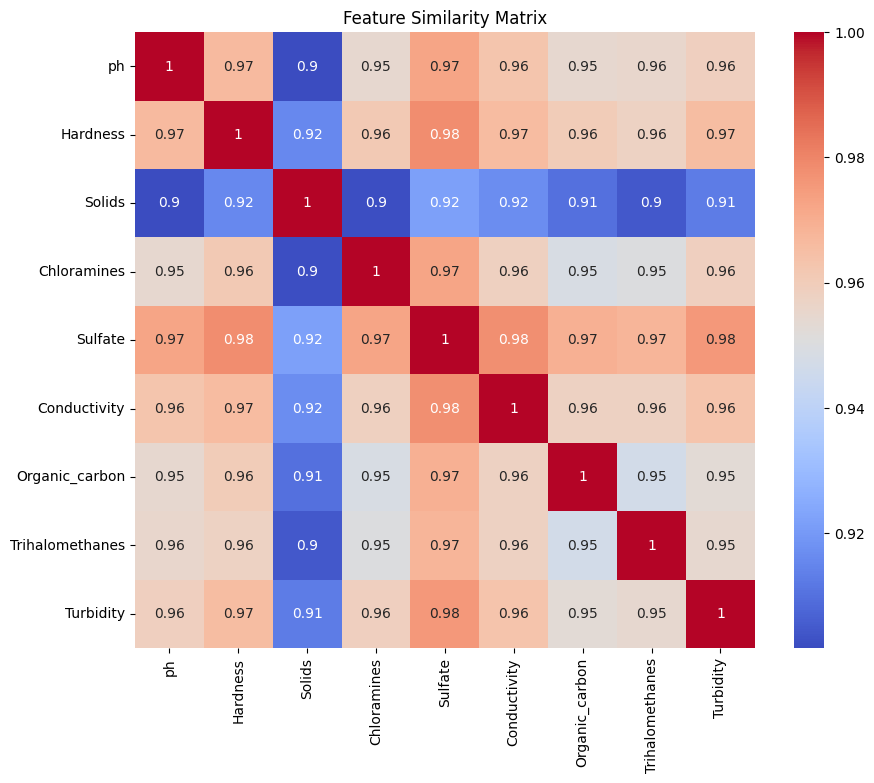

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA  # Import a classical optimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler  # Correct import for Sampler
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df_water = pd.read_csv("./water_potability.csv")
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Train-validation-test split
df_train_full, df_test = train_test_split(df_water, test_size=0.2, shuffle=True, random_state=42)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, shuffle=True, random_state=42)
X_train = df_train[features]
X_valid = df_valid[features]
X_test = df_test[features]
y_train = df_train['Potability']
y_valid = df_valid['Potability']
y_test = df_test['Potability']

# Define the hyperparameter optimization problem
problem = QuadraticProgram()

# Add binary variables for hyperparameters
problem.binary_var('num_leaves_31')
problem.binary_var('num_leaves_50')
problem.binary_var('max_depth_5')
problem.binary_var('max_depth_10')
problem.binary_var('learning_rate_001')
problem.binary_var('learning_rate_05')

# Define a very basic objective function (this is just a placeholder for the actual objective)
problem.minimize(linear={'num_leaves_31': 1, 'num_leaves_50': 2, 'max_depth_5': 3, 'max_depth_10': 4, 'learning_rate_001': 5, 'learning_rate_05': 6})

# Quantum optimization using QAOA with AerSimulator
quantum_backend = AerSimulator()

# Initialize the Sampler
sampler = Sampler()  # No backend argument needed

# Classical optimizer
optimizer = COBYLA()

# Initialize QAOA with the optimizer and sampler
qaoa = QAOA(optimizer=optimizer, sampler=sampler)

# Initialize Minimum Eigen Optimizer
minimum_eigen_optimizer = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = minimum_eigen_optimizer.solve(problem)
print(result)

# Interpret the results to set hyperparameters
num_leaves = 31 if result.x[0] else 50
max_depth = 5 if result.x[2] else 10
learning_rate = 0.001 if result.x[4] else 0.05

# Train LightGBM with optimized hyperparameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': 1
}

clf = lgb.LGBMClassifier(**params, n_estimators=1000)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss', callbacks=[lgb.early_stopping(stopping_rounds=30)])

# Evaluate the model
y_test_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

# print(f"Test Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

X_test_filled = X_test.fillna(X_test.mean())
similarity_matrix = cosine_similarity(X_test_filled.T)
labels = X_test.columns
sim_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Feature Similarity Matrix')
plt.show()


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=

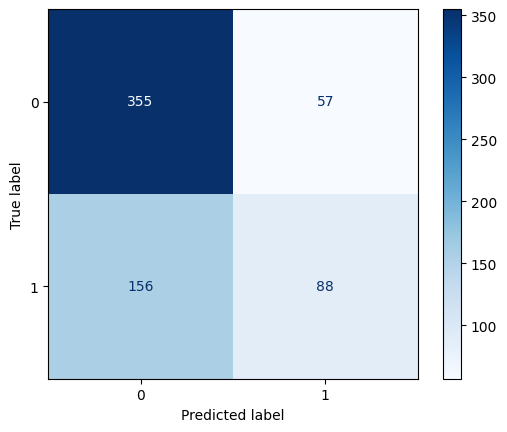

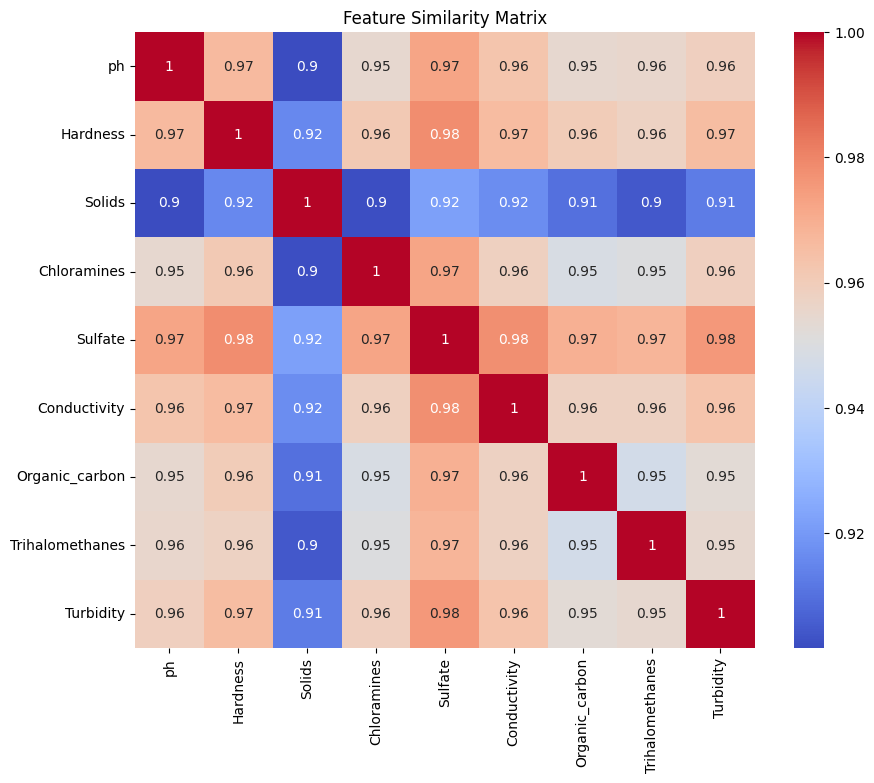

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA  # Import a classical optimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler  # Correct import for Sampler
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df_water = pd.read_csv("./water_potability.csv")
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Train-validation-test split
df_train_full, df_test = train_test_split(df_water, test_size=0.2, shuffle=True, random_state=42)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, shuffle=True, random_state=42)
X_train = df_train[features]
X_valid = df_valid[features]
X_test = df_test[features]
y_train = df_train['Potability']
y_valid = df_valid['Potability']
y_test = df_test['Potability']

# Baseline LightGBM model without quantum optimization
params_baseline = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': 1
}

clf_baseline = lgb.LGBMClassifier(**params_baseline, n_estimators=1000)
clf_baseline.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss', callbacks=[lgb.early_stopping(stopping_rounds=30)])

# Evaluate the baseline model
y_test_pred_baseline = clf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_test_pred_baseline)
recall_baseline = recall_score(y_test, y_test_pred_baseline)
precision_baseline = precision_score(y_test, y_test_pred_baseline)

print(f"Baseline Model - Accuracy: {accuracy_baseline:.3f}, Recall: {recall_baseline:.3f}, Precision: {precision_baseline:.3f}")

# Define the hyperparameter optimization problem for quantum optimization
problem = QuadraticProgram()

# Add binary variables for hyperparameters
problem.binary_var('num_leaves_31')
problem.binary_var('num_leaves_50')
problem.binary_var('max_depth_5')
problem.binary_var('max_depth_10')
problem.binary_var('learning_rate_001')
problem.binary_var('learning_rate_05')

# Define a very basic objective function (this is just a placeholder for the actual objective)
problem.minimize(linear={'num_leaves_31': 1, 'num_leaves_50': 2, 'max_depth_5': 3, 'max_depth_10': 4, 'learning_rate_001': 5, 'learning_rate_05': 6})

# Quantum optimization using QAOA with AerSimulator
quantum_backend = AerSimulator()

# Initialize the Sampler
sampler = Sampler()  # No backend argument needed

# Classical optimizer
optimizer = COBYLA()

# Initialize QAOA with the optimizer and sampler
qaoa = QAOA(optimizer=optimizer, sampler=sampler)

# Initialize Minimum Eigen Optimizer
minimum_eigen_optimizer = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = minimum_eigen_optimizer.solve(problem)
print(result)

# Interpret the results to set hyperparameters
num_leaves = 31 if result.x[0] else 50
max_depth = 5 if result.x[2] else 10
learning_rate = 0.001 if result.x[4] else 0.05

# Train LightGBM with quantum-optimized hyperparameters
params_quantum = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': 1
}

clf_quantum = lgb.LGBMClassifier(**params_quantum, n_estimators=1000)
clf_quantum.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss', callbacks=[lgb.early_stopping(stopping_rounds=30)])

# Evaluate the quantum-optimized model
y_test_pred_quantum = clf_quantum.predict(X_test)
accuracy_quantum = accuracy_score(y_test, y_test_pred_quantum)
recall_quantum = recall_score(y_test, y_test_pred_quantum)
precision_quantum = precision_score(y_test, y_test_pred_quantum)

print(f"Quantum Optimized Model - Accuracy: {accuracy_quantum:.3f}, Recall: {recall_quantum:.3f}, Precision: {precision_quantum:.3f}")

# Comparison
print("\nComparison of Baseline and Quantum-Optimized Models:")
print(f"Baseline Model - Accuracy: {accuracy_baseline:.3f}, Recall: {recall_baseline:.3f}, Precision: {precision_baseline:.3f}")
print(f"Quantum Optimized Model - Accuracy: {accuracy_quantum:.3f}, Recall: {recall_quantum:.3f}, Precision: {precision_quantum:.3f}")

# Confusion Matrix for Quantum-Optimized Model
cm = confusion_matrix(y_test, y_test_pred_quantum)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_quantum.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Similarity Matrix for Quantum-Optimized Model
X_test_filled = X_test.fillna(X_test.mean())
similarity_matrix = cosine_similarity(X_test_filled.T)
labels = X_test.columns
sim_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Feature Similarity Matrix')
plt.show()


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=

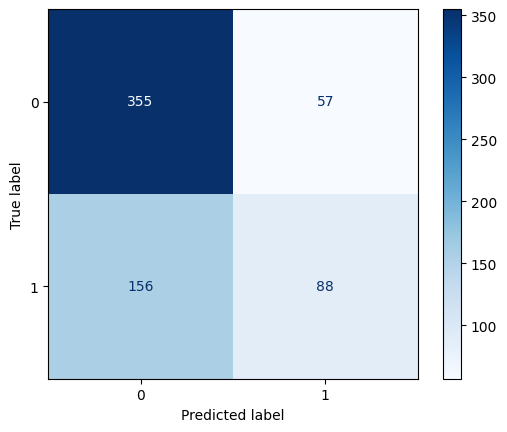

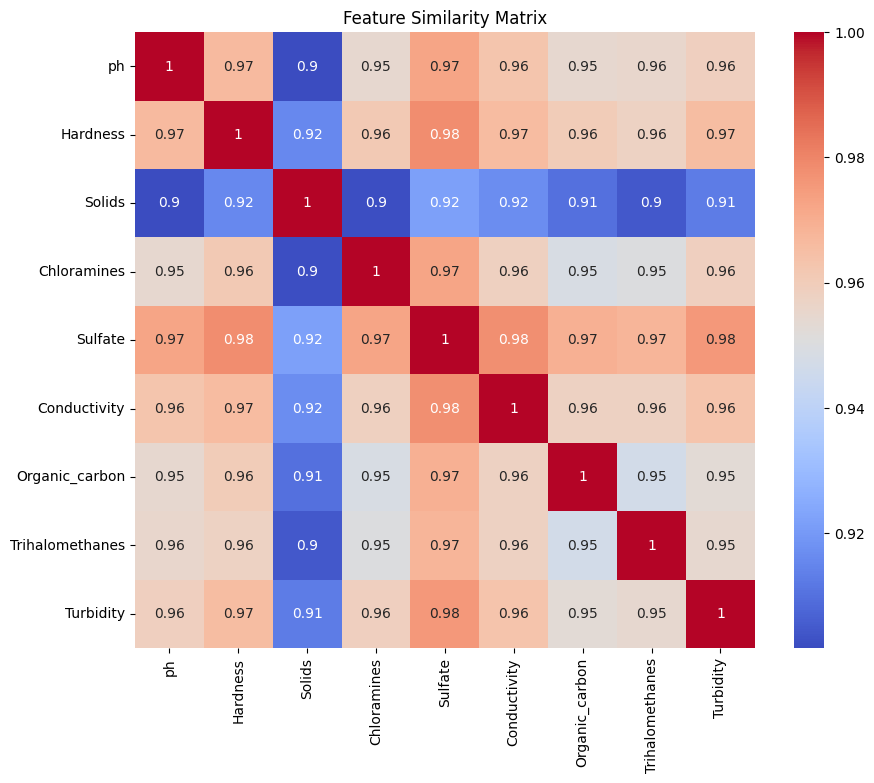

In [15]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA  # Import a classical optimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler  # Correct import for Sampler
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df_water = pd.read_csv("./water_potability.csv")
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Train-validation-test split
df_train_full, df_test = train_test_split(df_water, test_size=0.2, shuffle=True, random_state=42)
df_train, df_valid = train_test_split(df_train_full, test_size=0.25, shuffle=True, random_state=42)
X_train = df_train[features]
X_valid = df_valid[features]
X_test = df_test[features]
y_train = df_train['Potability']
y_valid = df_valid['Potability']
y_test = df_test['Potability']

# Baseline LightGBM model without quantum optimization
params_baseline = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': 1
}

clf_baseline = lgb.LGBMClassifier(**params_baseline, n_estimators=1000)
clf_baseline.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss', callbacks=[lgb.early_stopping(stopping_rounds=30)])

# Evaluate the baseline model
y_test_pred_baseline = clf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_test_pred_baseline)
recall_baseline = recall_score(y_test, y_test_pred_baseline)
precision_baseline = precision_score(y_test, y_test_pred_baseline)

print(f"Baseline Model - Accuracy: {accuracy_baseline:.3f}, Recall: {recall_baseline:.3f}, Precision: {precision_baseline:.3f}")

# Define the hyperparameter optimization problem with a quadratic objective function
problem = QuadraticProgram()

# Add binary variables for hyperparameters
num_leaves_31 = problem.binary_var('num_leaves_31')
num_leaves_50 = problem.binary_var('num_leaves_50')
max_depth_5 = problem.binary_var('max_depth_5')
max_depth_10 = problem.binary_var('max_depth_10')
learning_rate_001 = problem.binary_var('learning_rate_001')
learning_rate_05 = problem.binary_var('learning_rate_05')

# Define a quadratic objective function
# Example: Create some interaction terms to simulate more complex relationships
problem.minimize(linear={'num_leaves_31': 2, 'num_leaves_50': 3, 'max_depth_5': 4, 'max_depth_10': 5, 'learning_rate_001': 6, 'learning_rate_05': 7},
                 quadratic={('num_leaves_31', 'max_depth_5'): 3,
                            ('num_leaves_50', 'max_depth_10'): 4,
                            ('learning_rate_001', 'learning_rate_05'): 2})

# Quantum optimization using QAOA with AerSimulator
quantum_backend = AerSimulator()

# Initialize the Sampler
sampler = Sampler()  # No backend argument needed

# Classical optimizer
optimizer = COBYLA()

# Initialize QAOA with the optimizer and sampler
qaoa = QAOA(optimizer=optimizer, sampler=sampler)

# Initialize Minimum Eigen Optimizer
minimum_eigen_optimizer = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = minimum_eigen_optimizer.solve(problem)
print(result)

# Interpret the results to set hyperparameters
num_leaves = 31 if result.x[0] else 50
max_depth = 5 if result.x[2] else 10
learning_rate = 0.001 if result.x[4] else 0.05

# Train LightGBM with quantum-optimized hyperparameters
params_quantum = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': 1
}

clf_quantum = lgb.LGBMClassifier(**params_quantum, n_estimators=1000)
clf_quantum.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss', callbacks=[lgb.early_stopping(stopping_rounds=30)])

# Evaluate the quantum-optimized model
y_test_pred_quantum = clf_quantum.predict(X_test)
accuracy_quantum = accuracy_score(y_test, y_test_pred_quantum)
recall_quantum = recall_score(y_test, y_test_pred_quantum)
precision_quantum = precision_score(y_test, y_test_pred_quantum)

print(f"Quantum Optimized Model - Accuracy: {accuracy_quantum:.3f}, Recall: {recall_quantum:.3f}, Precision: {precision_quantum:.3f}")

# Comparison
print("\nComparison of Baseline and Quantum-Optimized Models:")
print(f"Baseline Model - Accuracy: {accuracy_baseline:.3f}, Recall: {recall_baseline:.3f}, Precision: {precision_baseline:.3f}")
print(f"Quantum Optimized Model - Accuracy: {accuracy_quantum:.3f}, Recall: {recall_quantum:.3f}, Precision: {precision_quantum:.3f}")

# Confusion Matrix for Quantum-Optimized Model
cm = confusion_matrix(y_test, y_test_pred_quantum)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_quantum.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Similarity Matrix for Quantum-Optimized Model
X_test_filled = X_test.fillna(X_test.mean())
similarity_matrix = cosine_similarity(X_test_filled.T)
labels = X_test.columns
sim_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Feature Similarity Matrix')
plt.show()


In [5]:
# Required imports
import pandas as pd
import numpy as np
from qiskit import Aer, execute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Load the data
df_water = pd.read_csv("./water_potability.csv")

# Data preprocessing
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
X = df_water[features].fillna(df_water.mean())
y = df_water['Potability']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantum feature map
feature_map = ZZFeatureMap(feature_dimension=len(features), reps=2)

# Function to apply quantum feature map
def quantum_transform(X, feature_map):
    simulator = AerSimulator()
    quantum_instance = QuantumInstance(simulator)
    transformed_X = []

    for x in X.values:
        # Prepare quantum circuit
        circuit = feature_map.bind_parameters(x)
        circuit.measure_all()

        # Execute the quantum circuit
        result = execute(circuit, backend=quantum_instance.backend, shots=1).result()
        counts = result.get_counts()

        # Convert quantum result to a classical binary vector
        binary_vector = [counts.get(bin_str, 0) for bin_str in sorted(counts)]
        transformed_X.append(binary_vector)

    return np.array(transformed_X)

# Apply the quantum transformation to the training and test sets
X_train_transformed = quantum_transform(X_train, feature_map)
X_test_transformed = quantum_transform(X_test, feature_map)

# Train a LightGBM model on the quantum-transformed data
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'verbosity': -1
}

clf = lgb.LGBMClassifier(**params, n_estimators=1000)
clf.fit(X_train_transformed, y_train)

# Evaluate the model
y_train_pred = clf.predict(X_train_transformed)
y_test_pred = clf.predict(X_test_transformed)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))


C:\Users\Shreya Rajpal\AppData\Local\Temp\ipykernel_14356\1254801003.py:29: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(simulator)
C:\Users\Shreya Rajpal\AppData\Local\Temp\ipykernel_14356\1254801003.py:34: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  circuit = feature_map.bind_parameters(x)
C:\Users\Shreya Rajpal\AppData\Local\Temp\ipykernel_14356\1254801003.py:38: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sa

Training Accuracy: 0.6053435114503817
Test Accuracy: 0.6280487804878049
Test Recall: 0.0
Test Precision: 0.0


C:\Users\Shreya Rajpal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
X_test_transformed

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [6]:
# Required imports
import pandas as pd
import numpy as np
from qiskit import Aer, transpile, execute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Load the data
df_water = pd.read_csv("./water_potability.csv")

# Data preprocessing
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
X = df_water[features].fillna(df_water.mean())
y = df_water['Potability']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantum PCA Implementation (Simplified Version)
def quantum_pca(X, num_components=2):
    simulator = AerSimulator()
    n = X.shape[1]  # Number of features
    feature_map = ZZFeatureMap(feature_dimension=n, reps=1)

    principal_components = []
    for i in range(num_components):
        component = []
        for x in X:
            # Prepare quantum circuit
            circuit = feature_map.assign_parameters(x)
            
            # Add measurements to the circuit
            qc = QuantumCircuit(n, n)
            qc.compose(circuit, inplace=True)
            qc.measure(range(n), range(n))

            # Transpile and run the quantum circuit
            transpiled_circuit = transpile(qc, simulator)
            job = simulator.run(transpiled_circuit, shots=1024)
            result = job.result()
            counts = result.get_counts()

            # Simplified approach: calculate the expectation value of Z on the first qubit
            expectation_value = 0
            for outcome, count in counts.items():
                parity = (-1) ** (outcome.count('1'))
                expectation_value += parity * count
            expectation_value /= 1024  # Normalize by the number of shots
            component.append(expectation_value)
        principal_components.append(component)

    return np.array(principal_components).T

# Apply Quantum PCA to the training and test sets
X_train_reduced = quantum_pca(X_train.values)
X_test_reduced = quantum_pca(X_test.values)

# Train a LightGBM model on the quantum-reduced data
clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
clf.fit(X_train_reduced, y_train)

# Evaluate the model
y_train_pred = clf.predict(X_train_reduced)
y_test_pred = clf.predict(X_test_reduced)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))


Training Accuracy: 0.7049618320610687
Test Accuracy: 0.5792682926829268
Test Recall: 0.21311475409836064
Test Precision: 0.38235294117647056


In [1]:
import pandas as pd
import numpy as np
from qiskit import Aer, transpile, execute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Load the data
df_water = pd.read_csv("./water_potability.csv")

# Based on the similarity matrix, we will drop features that are highly correlated.
# For example, if 'Hardness' and 'Sulfate' are highly correlated, we can drop one of them.
features = ['ph', 'Chloramines', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']  # Keeping only less correlated features
X = df_water[features].fillna(df_water.mean())
y = df_water['Potability']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantum PCA Implementation (Simplified Version)
def quantum_pca(X, num_components=2):
    simulator = AerSimulator()
    n = X.shape[1]  # Number of features
    feature_map = ZZFeatureMap(feature_dimension=n, reps=1)

    principal_components = []
    for i in range(num_components):
        component = []
        for x in X:
            # Prepare quantum circuit
            circuit = feature_map.assign_parameters(x)
            
            # Add measurements to the circuit
            qc = QuantumCircuit(n, n)
            qc.compose(circuit, inplace=True)
            qc.measure(range(n), range(n))

            # Transpile and run the quantum circuit
            transpiled_circuit = transpile(qc, simulator)
            job = simulator.run(transpiled_circuit, shots=1024)
            result = job.result()
            counts = result.get_counts()

            # Simplified approach: calculate the expectation value of Z on the first qubit
            expectation_value = 0
            for outcome, count in counts.items():
                parity = (-1) ** (outcome.count('1'))
                expectation_value += parity * count
            expectation_value /= 1024  # Normalize by the number of shots
            component.append(expectation_value)
        principal_components.append(component)

    return np.array(principal_components).T

# Apply Quantum PCA to the training and test sets
X_train_reduced = quantum_pca(X_train.values)
X_test_reduced = quantum_pca(X_test.values)

# Train a LightGBM model on the quantum-reduced data
clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
clf.fit(X_train_reduced, y_train)

# Evaluate the model
y_train_pred = clf.predict(X_train_reduced)
y_test_pred = clf.predict(X_test_reduced)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))


Training Accuracy: 0.7087786259541985
Test Accuracy: 0.573170731707317
Test Recall: 0.20081967213114754
Test Precision: 0.3656716417910448


Training and evaluating Gradient Boosting Classifier...
Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



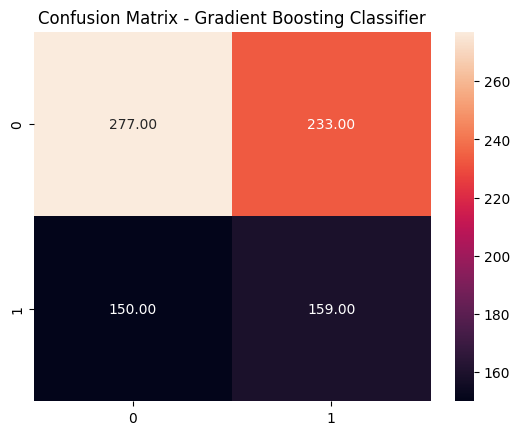

Training and evaluating Bagging Classifier...
Bagging Classifier Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       510
           1       0.37      0.46      0.41       309

    accuracy                           0.50       819
   macro avg       0.49      0.49      0.49       819
weighted avg       0.52      0.50      0.50       819



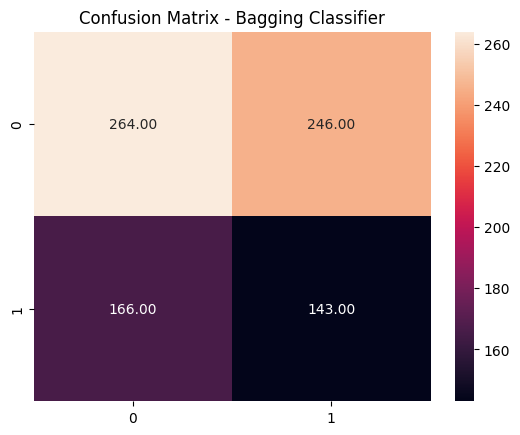

In [3]:
# Load libraries
import numpy as np
import pandas as pd
from qiskit import Aer, transpile, execute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df= pd.read_csv("./water_potability.csv")

# Preprocess data as before (handling missing values, scaling, and SMOTE)
df['ph']=df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

# Handling imbalance and scaling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

samp = SMOTE()
X = df.drop(['Potability'], axis=1)
y = df['Potability']
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, y_train = samp.fit_resample(X_train, y_train)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

# Quantum PCA Implementation (Simplified Version)
def quantum_pca(X, num_components=2):
    simulator = AerSimulator()
    n = X.shape[1]  # Number of features
    feature_map = ZZFeatureMap(feature_dimension=n, reps=1)

    principal_components = []
    for i in range(num_components):
        component = []
        for x in X:
            # Prepare quantum circuit
            circuit = feature_map.assign_parameters(x)
            
            # Add measurements to the circuit
            qc = QuantumCircuit(n, n)
            qc.compose(circuit, inplace=True)
            qc.measure(range(n), range(n))

            # Transpile and run the quantum circuit
            transpiled_circuit = transpile(qc, simulator)
            job = simulator.run(transpiled_circuit, shots=1024)
            result = job.result()
            counts = result.get_counts()

            # Simplified approach: calculate the expectation value of Z on the first qubit
            expectation_value = 0
            for outcome, count in counts.items():
                parity = (-1) ** (outcome.count('1'))
                expectation_value += parity * count
            expectation_value /= 1024  # Normalize by the number of shots
            component.append(expectation_value)
        principal_components.append(component)

    return np.array(principal_components).T

# Apply Quantum PCA to the training and test sets
X_train_reduced = quantum_pca(X_train)
X_test_reduced = quantum_pca(X_test)

# Train and evaluate the Gradient Boosting model
print("Training and evaluating Gradient Boosting Classifier...")
model_gb = GradientBoostingClassifier(n_estimators=300)
model_gb.fit(X_train_reduced, y_train)
pred_gb = model_gb.predict(X_test_reduced)
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, pred_gb))
sns.heatmap(confusion_matrix(y_test, pred_gb), annot=True, fmt='.2f')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

# Train and evaluate the Bagging Classifier model
print("Training and evaluating Bagging Classifier...")
model_bag = BaggingClassifier(n_estimators=80)
model_bag.fit(X_train_reduced, y_train)
pred_bag = model_bag.predict(X_test_reduced)
print("Bagging Classifier Report:")
print(classification_report(y_test, pred_bag))
sns.heatmap(confusion_matrix(y_test, pred_bag), annot=True, fmt='.2f')
plt.title('Confusion Matrix - Bagging Classifier')
plt.show()


In [1]:
# # Required imports
# import numpy as np
# import pandas as pd
# from qiskit import Aer, transpile, execute
# from qiskit.circuit.library import ZZFeatureMap
# from qiskit.circuit import QuantumCircuit
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Load the data
# df = pd.read_csv("./water_potability.csv")

# # Preprocess data as before (handling missing values, scaling, and SMOTE)
# df['ph'] = df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
# df['Sulfate'] = df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
# df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

# # Handling imbalance and scaling
# samp = SMOTE()
# X = df.drop(['Potability'], axis=1)
# y = df['Potability']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# X_train, y_train = samp.fit_resample(X_train, y_train)

# scale = StandardScaler()
# X_train = scale.fit_transform(X_train)
# X_test = scale.transform(X_test)

# # Define the quantum kernel calculation function
# def quantum_kernel(X1, X2):
#     simulator = Aer.get_backend('qasm_simulator')
#     n_features = X1.shape[1]
#     feature_map = ZZFeatureMap(feature_dimension=n_features, reps=2)

#     kernel_matrix = np.zeros((X1.shape[0], X2.shape[0]))

#     for i, x1 in enumerate(X1):
#         for j, x2 in enumerate(X2):
#             # Create quantum circuits for each pair of data points
#             qc1 = QuantumCircuit(n_features)
#             qc2 = QuantumCircuit(n_features)
#             qc1.compose(feature_map.assign_parameters(x1), inplace=True)
#             qc2.compose(feature_map.assign_parameters(x2), inplace=True)
            
#             # Combine the circuits to measure the inner product
#             qc = qc1.compose(qc2.inverse())
#             qc.measure_all()

#             # Execute the quantum circuit
#             transpiled_qc = transpile(qc, simulator)
#             result = execute(transpiled_qc, backend=simulator, shots=1024).result()
#             counts = result.get_counts()
            
#             # Calculate the kernel value as the probability of measuring '0...0'
#             kernel_value = counts.get('0' * n_features, 0) / 1024
#             kernel_matrix[i, j] = kernel_value

#     return kernel_matrix

# # Calculate the quantum kernel matrix for training and testing data
# print("Calculating quantum kernel for training data...")
# quantum_kernel_train = quantum_kernel(X_train, X_train)
# print("Calculating quantum kernel for test data...")
# quantum_kernel_test = quantum_kernel(X_test, X_train)

# # Train the SVM using the quantum kernel
# print("Training SVM with quantum kernel...")
# qsvc = SVC(kernel='precomputed')
# qsvc.fit(quantum_kernel_train, y_train)

# # Predict using QSVM
# y_pred_qsvc = qsvc.predict(quantum_kernel_test)

# # Evaluate the QSVM model
# print("QSVM Classification Report:")
# print(classification_report(y_test, y_pred_qsvc))
# sns.heatmap(confusion_matrix(y_test, y_pred_qsvc), annot=True, fmt='.2f')
# plt.title('Confusion Matrix - QSVM')
# plt.show()

# # Classical Linear SVC
# # Initialize the Linear SVC model
# print("Training Linear Support Vector Classifier (SVC)...")
# svc = SVC(kernel='linear')
# svc.fit(X_train, y_train)

# # Predict using Linear SVC
# y_pred_svc = svc.predict(X_test)

# # Evaluate the Linear SVC model
# print("Linear SVC Classification Report:")
# print(classification_report(y_test, y_pred_svc))
# sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, fmt='.2f')
# plt.title('Confusion Matrix - Linear SVC')
# plt.show()

# # Compare the accuracy of QSVM and Linear SVC
# print("QSVM Accuracy:", accuracy_score(y_test, y_pred_qsvc))
# print("Linear SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
